# Convolutional Neural Network (CNN)



In this practical session, you will implement your first CNN and see new basis when training a network:
* how to save a network and then download it to predict on unseen data,
* how to implement early-stopping based on the validation loss.

We will use a remote sensing benchmarked dataset: UCMerced. This is a 21 class land use image dataset developed for research purposes in the community.

There are 100 images for each of the following classes:

    agricultural
    airplane
    baseballdiamond
    beach
    buildings
    chaparral
    denseresidential
    forest
    freeway
    golfcourse
    harbor
    intersection
    mediumresidential
    mobilehomepark
    overpass
    parkinglot
    river
    runway
    sparseresidential
    storagetanks
    tenniscourt

Each image is composed of 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot (approx 30 cm). 

More information on the dataset: [URL](http://weegee.vision.ucmerced.edu/datasets/landuse.html)

## Downloading the data

In [1]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip UCMerced_LandUse.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Training our first CNN models

Let us start by training our first CNN architecture. We will reimplement [LeNet-5](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) architecture.

Before defining our architecture, let us start by several compulsory steps:
1. downloading some packages
2. instantiating a data loader

In [3]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

In [4]:
batch_size = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

total_dataset = datasets.ImageFolder('./UCMerced_LandUse/Images', transform=transform)
print("Total number of images: ", len(total_dataset))
train_size = int(0.5 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print("Training set size: ", len(train_dataset))
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
print("Validation set size: ", len(val_dataset))
val_dataset_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
print("Test set size: ", len(test_dataset))
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


Total number of images:  2100
Training set size:  735
Validation set size:  315
Test set size:  1050


In [5]:
#-- An example training data (Tensor+label)
print(train_dataset[0])
print(train_dataset[0][0].shape)

(tensor([[[0.7059, 0.7255, 0.6784,  ..., 0.6941, 0.6549, 0.6784],
         [0.6863, 0.7451, 0.7255,  ..., 0.6784, 0.6824, 0.6745],
         [0.6235, 0.8196, 0.7255,  ..., 0.6706, 0.6706, 0.6902],
         ...,
         [0.3333, 0.3608, 0.3412,  ..., 0.3176, 0.5255, 0.5922],
         [0.4039, 0.3647, 0.3020,  ..., 0.1686, 0.4196, 0.5255],
         [0.4314, 0.3922, 0.3255,  ..., 0.1765, 0.4392, 0.5137]],

        [[0.7176, 0.6941, 0.6078,  ..., 0.7098, 0.6706, 0.6941],
         [0.6902, 0.7059, 0.6549,  ..., 0.6941, 0.6980, 0.6863],
         [0.6157, 0.7725, 0.6471,  ..., 0.6784, 0.6784, 0.7020],
         ...,
         [0.3373, 0.3647, 0.3451,  ..., 0.2863, 0.4863, 0.5294],
         [0.4078, 0.3686, 0.3059,  ..., 0.1843, 0.4118, 0.4863],
         [0.4353, 0.3961, 0.3294,  ..., 0.2118, 0.4588, 0.5137]],

        [[0.6510, 0.6431, 0.5686,  ..., 0.7451, 0.7059, 0.7294],
         [0.6196, 0.6588, 0.6157,  ..., 0.7373, 0.7412, 0.7216],
         [0.5569, 0.7255, 0.6196,  ..., 0.7255, 0.7255, 0

In [6]:
print(train_dataset[0][1])

20


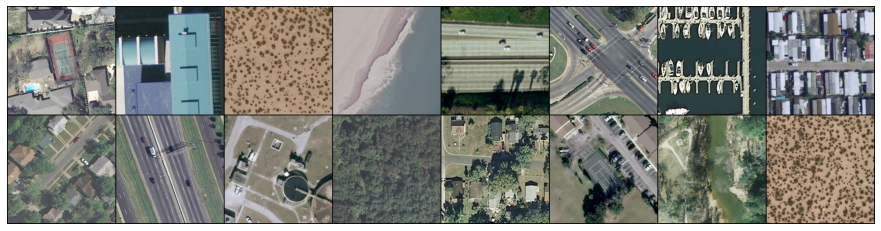

In [7]:
# Visualizing the data
from torchvision.utils import make_grid

def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_dataset_loader)
images, labels = dataiter.next()
show_images(make_grid(images))

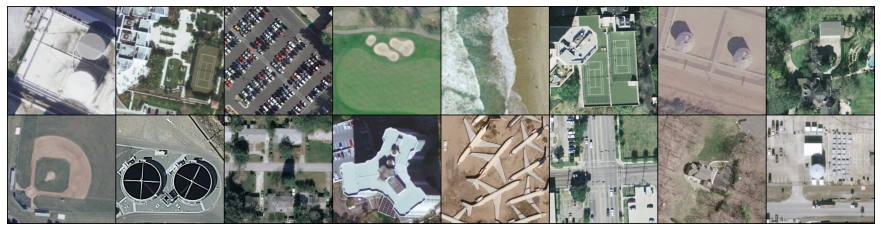

In [8]:
dataiter.next()
images, labels = dataiter.next()
show_images(make_grid(images))

Let us now implement a class for the [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture, which is composed of:
* 3 convolutions layers followed by a max-pooling operation (for computational reason, an extra max-pooling has been added in the class below)
* 2 fully-connected layers

In [9]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet5, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
       
        #-- fully connected layers
        self.fc1 = nn.Linear(120*28*28, 84)
        self.fc2 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

Let us also use the GPU power! (The model and inputs will be moved to GPU in "the training cell".

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# Loss function
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y)

In [12]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = LeNet5(3, 21)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=.01)

for e in range(epochs):
  model.train()
  train_correct = 0
  for x_train_batch, y_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item()/len(x_train_batch))
  
  train_accuracy.append(train_correct/len(train_dataset_loader.dataset)) 

  model.eval() # notify all the layers that you are in eval mode (useful for batch norm, dropout, etc)
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad(): #  impacts the autograd engine and deactivate it.
    #--                    reduce memory usage and speed up computations.
    for x_val_batch, y_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)
      y_val_batch = y_train_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch)
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss   
  val_accuracy.append(val_correct/len(val_dataset_loader.dataset))

In [13]:
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=94080, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=21, bias=True)
)


In [14]:
type(val_accuracy)
type(train_accuracy)

list

The training of this network is quite long (~5 minutes on GPU). Use this time to draw this CNN architecture (on a paper) and indicate the size of each activation map. Then, compute the number of trainable parameters (use a calculator).

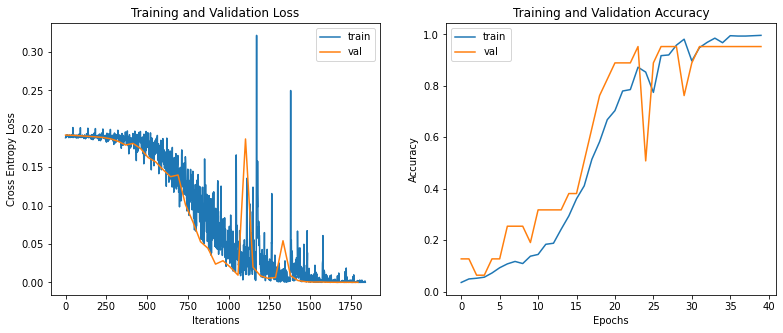

In [15]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]
val_accuracy = [t.cpu().detach() for t in val_accuracy]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [16]:
del model

We now try another architecture to see if we can improve this first result. The new architecture will have two more convolutional layers, but less trainable parameters.



First complete the code below `TOBECOMPLETED` with the correct value in the fully-connected layer

In [17]:
class LeNet7(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet7, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
       
        #-- fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

To help the readability, improve the structure, and ease the maintability, we first perform code refactoring by defining two functions:
* `train_epoch`
* `val_epoch`

In [18]:
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item()/len(x_train_batch))
  
  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy

def val_epoch(model, loss_func, dataloader, device):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_train_batch.to(device)
      y_val_batch = y_train_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch)
  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss   
  val_accuracy = val_correct/len(dataloader.dataset)

  return val_loss, val_accuracy


In [19]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = LeNet7(3, 21)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for e in range(epochs):
    
  epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_dataset_loader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_dataset_loader, device)

  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

During the training of this network, draw the corresponding architecture (LeNet7) and compute the number of trainable parameters.

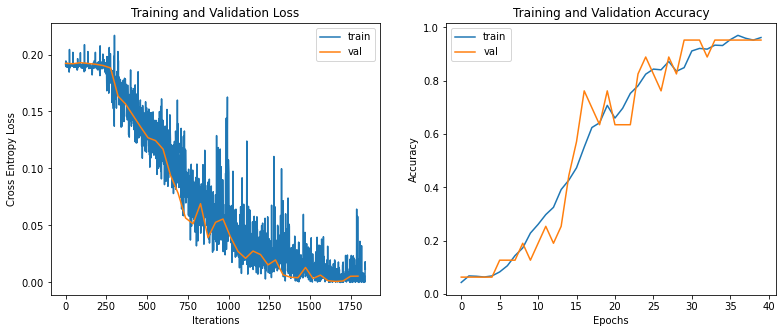

In [20]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]
val_accuracy = [t.cpu().detach() for t in val_accuracy]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [21]:
# number of trainable parameters Le-Net7
(5*5*3*32 + 32)+ (5*5*32*64 + 64) + (5*5*64*64 + 64) + (5*5*64*128 + 128) + (5*5*128*128 +128) + (128*4*4*128 +128) + (128*21 + 21)

1035797

## Verification

You can check the computations of the number parameters by using the following code: 

In [22]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [23]:
model5 = LeNet5(3, 21)
count_parameters(model5)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
| conv3.weight |   48000    |
|  conv3.bias  |    120     |
|  fc1.weight  |  7902720   |
|   fc1.bias   |     84     |
|  fc2.weight  |    1764    |
|   fc2.bias   |     21     |
+--------------+------------+
Total Trainable Params: 7955581


In [24]:
model5 = LeNet7(3, 21)
count_parameters(model5)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    2400    |
|  conv1.bias  |     32     |
| conv2.weight |   51200    |
|  conv2.bias  |     64     |
| conv3.weight |   102400   |
|  conv3.bias  |     64     |
| conv4.weight |   204800   |
|  conv4.bias  |    128     |
| conv5.weight |   409600   |
|  conv5.bias  |    128     |
|  fc1.weight  |   262144   |
|   fc1.bias   |    128     |
|  fc2.weight  |    2688    |
|   fc2.bias   |     21     |
+--------------+------------+
Total Trainable Params: 1035797


In [25]:
del model
del model5

## Save a model

We will now see how to save the model that has the lowest validation loss.

In PyTorch, the learnable parameters (i.e. weights and biases) of an `torch.nn.Module` model are contained in the model’s parameters (accessed with `model.parameters()`).  
The `state_dict` allows us to access to the parameter tensors of each tensor. This is a simple Python dictionary, which maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s `state_dict`. Optimizer objects (`torch.optim`) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [26]:
model = LeNet7(3,21)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 3, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([64, 64, 5, 5])
conv3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([128, 64, 5, 5])
conv4.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([128, 128, 5, 5])
conv5.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([128, 2048])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([21, 128])
fc2.bias 	 torch.Size([21])


### Saving / Loading a model for inference

When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s `state_dict` with the `torch.save()` function will give you the most flexibility for restoring the model later. This is the recommended method for saving models.



In [27]:
#-- Saving the model
torch.save(model.state_dict(), "mymodel.pth") # A common PyTorch convention is to save models using either a .pt or .pth file extension.

#-- Loading the model
model.load_state_dict(torch.load("mymodel.pth"))
model.eval() #-- if used for inference

LeNet7(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
)

### Saving / Loading a checkpoint for inference and/or resuming training

When saving a general checkpoint, to be used for either inference or resuming training, you must save more than just the model’s `state_dict`. It is important to also save the optimizer’s `state_dict`, as this contains buffers and parameters that are updated as the model trains. Other items that you may want to save are the epoch you left off on, the latest recorded training loss, etc. As a result, such a checkpoint is often 2~3 times larger than the model alone.

In [28]:
#-- Saving the model
torch.save({'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "bestmodel_checkpoint.pth")


checkpoint = torch.load("bestmodel_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval() # for inference
# model.train() # for resuming training

LeNet7(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=21, bias=True)
)

In [29]:
del model

### In practice

In [30]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = LeNet7(3, 21)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
min_val_loss = np.Inf
for e in range(epochs):
 
  epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_dataset_loader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_dataset_loader, device)
  
  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)
  if epoch_val_loss < min_val_loss: # early stopping technique
    min_val_loss = epoch_val_loss
    torch.save({'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "bestmodel_checkpoint.pth")

    

In [31]:
checkpoint = torch.load("bestmodel_checkpoint.pth")
print("Best model obtained on epoch: ", checkpoint['epoch'])


Best model obtained on epoch:  36


Do you observe a change in the training time?

It took relatively the same time, but appears the additional save step at each epoch increases the computational time. A good check could be to compare the performance of the model without using any hardware accelerator like the GPU, used in this case. 

## Early stopping

We can also early stop the training when there is no improvement made during the training. Usually, we define a `patience`, i.e. the number of epochs to wait before early stopping if there is no progress on the validation set.

In [32]:
del model

In [33]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 60 # number of epochs

model = LeNet7(3, 21)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

min_val_loss = np.Inf
counter = 0
patience = 5 #-- how long to wait after last time validation loss improved
delta_p = 0 #-- minimum change required in the monitored quantity (e.g. validation loss) to qualify as an improvement
for e in range(epochs):
  epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_dataset_loader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_dataset_loader, device)
  
  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)
  if epoch_val_loss < min_val_loss:
    min_val_loss = epoch_val_loss
    counter = 0
    torch.save({'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "bestmodel_checkpoint.pth")
  elif epoch_val_loss-min_val_loss > delta_p:
    counter = counter + 1

  if counter == patience:
    break


In [34]:
checkpoint = torch.load("bestmodel_checkpoint.pth")
stop_e = checkpoint['epoch']
print("Best model obtained on epoch: ", stop_e)

Best model obtained on epoch:  37


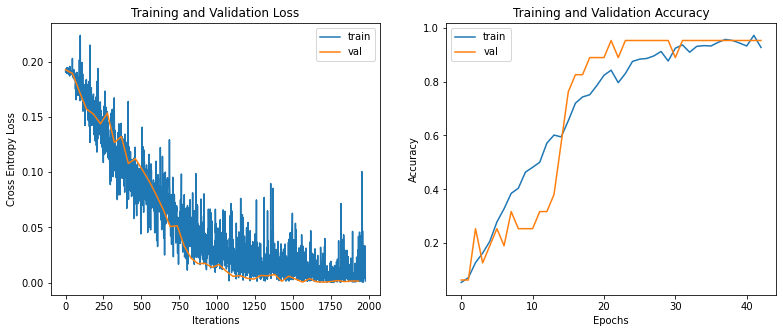

In [35]:
train_accuracy = [t.cpu().detach() for t in train_accuracy]
val_accuracy = [t.cpu().detach() for t in val_accuracy]

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(len(train_loss))),train_loss, label="train")
plt.plot(list(range(0, len(train_loss),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(len(train_accuracy))), train_accuracy, label="train")
plt.plot(list(range(len(val_accuracy))),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


Note that usually, during experimental phase (as opposed to operational phase), we train the network for a set of epochs to check the convergence and the model's behavior. From the saved results (train and validation loss), we then report the test accuracy for the model with a minimum validation loss.

# Your practice

In this section, you will train different networks. The main goal is to improve the performance (accuracy, convergence, etc.) of the "baseline" we trained in the previous section.

From the previous learning curves, you can observe that it takes few epochs before a decrease in the training loss. This is not an ideal learning curve. Try to improve the learning process by first identifying the issue (overfitting, underfitting, poor hyperparameter tuning), and then to correct it through the different exercises.

## Exercise 1: Impact of the architecture of the model


In this exercise, we will try different architecture. The goal is to find the architecture that give the most accurate predictions. We can also analyse the performance in terms of speed.
* Try to change the number of convolutional, max pooling, and fully-connected layers and their positions in the network.
* Try to change the number of filter in the convolutional layers (from a huge number to a smaller, with a constant number, etc.).

#### Tinkering with the number of convolutional, maxpooling and fully connected layers

##### 01. Adjust the Convolutional Layers and Fully Connected Layers

In [36]:
del model

In [37]:
class LeNet8(nn.Module):
  """
  Add a new Conv2Dlayer to the Let-Net7 architecture, 
  and two Linear Layers to the MLP component of the model architecture. 
  """
  def __init__(self, n_channels, n_classes):
        super(LeNet8, self).__init__()

        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv6 = nn.Conv2d(128, 256, 3)
       
        #-- fully connected layers
        self.fc1 = nn.Linear(256*1*1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_classes)
        
  def forward(self, x):
        # forward pass
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

In [38]:
# define functions to train and visualize model performance
def train_model(model, optimizer,  epochs = 60):
  train_loss = [] # where we keep track of the training lossep
  train_accuracy = [] # where we keep track of the training accuracy of the model
  val_loss = [] # where we keep track of the validation loss
  val_accuracy = [] # where we keep track of the validation accuracy of the model
  
  model.to(device)

  min_val_loss = np.Inf
  counter = 0
  patience = 5 #-- how long to wait after last time validation loss improved
  delta_p = 0 #-- tracking the model convergence
  
  for e in range(epochs):
    epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_dataset_loader, device)
    epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_dataset_loader, device)
    
    train_loss.extend(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)
    
    if epoch_val_loss < min_val_loss:
      min_val_loss = epoch_val_loss
      counter = 0
      torch.save({'epoch': e,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss
                  }, "bestmodel_checkpoint.pth")
      
    elif epoch_val_loss-min_val_loss > delta_p:
      counter = counter + 1
    
    if counter == patience:
      break

  return train_loss, train_accuracy, val_loss, val_accuracy


def visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy):
  train_accuracy = [t.cpu().detach() for t in train_accuracy]
  val_accuracy = [t.cpu().detach() for t in val_accuracy]

  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range(len(train_loss))),train_loss, label="train")
  plt.plot(list(range(0, len(train_loss),len(train_dataset_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(len(train_accuracy))), train_accuracy, label="train")
  plt.plot(list(range(len(val_accuracy))),val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


In [39]:
model = LeNet8(3, 21)
optimizer = optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    2400    |
|  conv1.bias  |     32     |
| conv2.weight |   51200    |
|  conv2.bias  |     64     |
| conv3.weight |   102400   |
|  conv3.bias  |     64     |
| conv4.weight |   204800   |
|  conv4.bias  |    128     |
| conv5.weight |   409600   |
|  conv5.bias  |    128     |
| conv6.weight |   294912   |
|  conv6.bias  |    256     |
|  fc1.weight  |   65536    |
|   fc1.bias   |    256     |
|  fc2.weight  |   32768    |
|   fc2.bias   |    128     |
|  fc3.weight  |    8192    |
|   fc3.bias   |     64     |
|  fc4.weight  |    1344    |
|   fc4.bias   |     21     |
+--------------+------------+
Total Trainable Params: 1174293


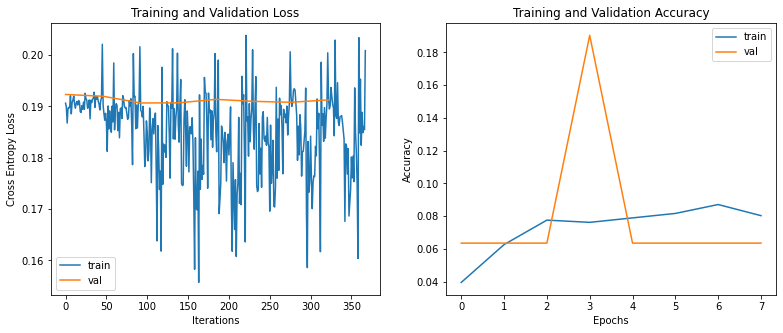

In [40]:
train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

##### 02. Adjust the Maxpooling functions and the activation functions

In [41]:
del model

In [42]:
x_train_batch[0].shape

torch.Size([3, 256, 256])

In [43]:
class LeNet8_U(nn.Module):
  """
  Add a new Conv2Dlayer to the Let-Net7 architecture, 
  and two Linear Layers to the MLP component of the model architecture.
  Adjust the structure of the MaxPool and Activation functions
  """
  def __init__(self, n_channels, n_classes):
        super(LeNet8_U, self).__init__()

        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv6 = nn.Conv2d(128, 256, 3)

        #-- fully connected layers
        self.fc1 = nn.Linear(256*1*1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_classes)
        
  def forward(self, x):
        # forward pass
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

In [44]:
model = LeNet8_U(3, 21)
optimizer = optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    2400    |
|  conv1.bias  |     32     |
| conv2.weight |   51200    |
|  conv2.bias  |     64     |
| conv3.weight |   102400   |
|  conv3.bias  |     64     |
| conv4.weight |   204800   |
|  conv4.bias  |    128     |
| conv5.weight |   409600   |
|  conv5.bias  |    128     |
| conv6.weight |   294912   |
|  conv6.bias  |    256     |
|  fc1.weight  |   65536    |
|   fc1.bias   |    256     |
|  fc2.weight  |   32768    |
|   fc2.bias   |    128     |
|  fc3.weight  |    8192    |
|   fc3.bias   |     64     |
|  fc4.weight  |    1344    |
|   fc4.bias   |     21     |
+--------------+------------+
Total Trainable Params: 1174293


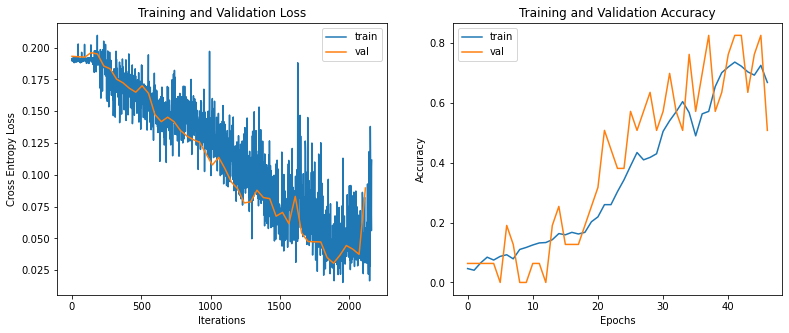

In [45]:
train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)

##### 03. Tinkering with the number of filters in the Baseline model (LeNet7).

In [62]:
del model

In [63]:
# pad the data.
class LeNet7_padded(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet7_padded, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 64, 7)
        self.conv2 = nn.Conv2d(64, 64, 7)
        self.conv3 = nn.Conv2d(64, 64, 7)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 7)
        self.conv6 = nn.Conv2d(128, 128, 3)
       
        #-- fully connected layers
        self.fc1 = nn.Linear(128*26*26, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        logits = self.fc5(x)
        return logits

In [64]:
model = LeNet7_padded(3, 21)
optimizer = optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    9408    |
|  conv1.bias  |     64     |
| conv2.weight |   200704   |
|  conv2.bias  |     64     |
| conv3.weight |   200704   |
|  conv3.bias  |     64     |
| conv4.weight |   204800   |
|  conv4.bias  |    128     |
| conv5.weight |   802816   |
|  conv5.bias  |    128     |
| conv6.weight |   147456   |
|  conv6.bias  |    128     |
|  fc1.weight  |  11075584  |
|   fc1.bias   |    128     |
|  fc2.weight  |    8192    |
|   fc2.bias   |     64     |
|  fc3.weight  |    2048    |
|   fc3.bias   |     32     |
|  fc4.weight  |    512     |
|   fc4.bias   |     16     |
|  fc5.weight  |    336     |
|   fc5.bias   |     21     |
+--------------+------------+
Total Trainable Params: 12653397


In [69]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [71]:
import gc
gc.collect()

5799

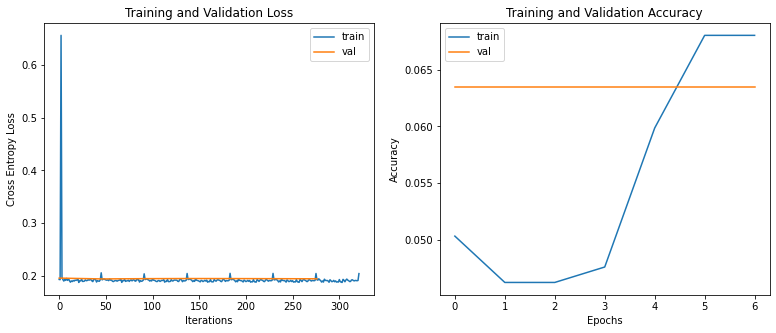

In [70]:
train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)

In [74]:
#del checkpoint
del model

with torch.no_grad():
    torch.cuda.empty_cache()

In [81]:
class LeNet8_Upt(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet8_Upt, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 128, 5)
        self.conv2 = nn.Conv2d(128, 128, 5)
        self.conv3 = nn.Conv2d(128, 64, 5)
        self.conv4 = nn.Conv2d(64, 32, 5)
        self.conv5 = nn.Conv2d(32, 16, 5)
        #self.conv6 = nn.Conv2d(16, 8, 5)

        #-- fully connected layers
        self.fc1 = nn.Linear(16*4*4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        #x = F.max_pool2d(F.relu(self.conv6(x)), 2)
        
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

In [82]:
model = LeNet8_Upt(3, 21)
optimizer = optim.Adam(model.parameters(), lr=0.001)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    9600    |
|  conv1.bias  |    128     |
| conv2.weight |   409600   |
|  conv2.bias  |    128     |
| conv3.weight |   204800   |
|  conv3.bias  |     64     |
| conv4.weight |   51200    |
|  conv4.bias  |     32     |
| conv5.weight |   12800    |
|  conv5.bias  |     16     |
|  fc1.weight  |    4096    |
|   fc1.bias   |     16     |
|  fc2.weight  |    512     |
|   fc2.bias   |     32     |
|  fc3.weight  |    2048    |
|   fc3.bias   |     64     |
|  fc4.weight  |    1344    |
|   fc4.bias   |     21     |
+--------------+------------+
Total Trainable Params: 696501


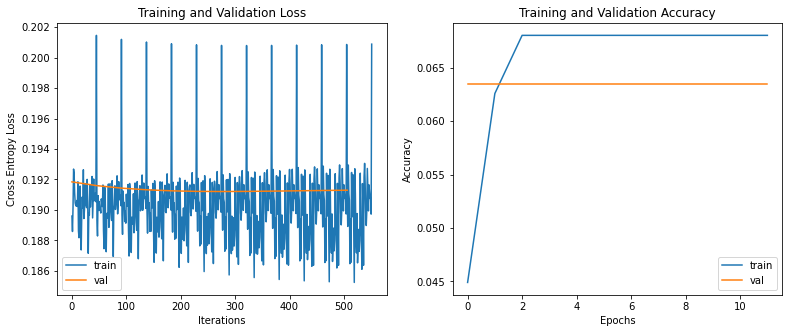

In [83]:
train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)

In [85]:
#del checkpoint
del model

with torch.no_grad():
    torch.cuda.empty_cache()

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

## Exercise 2: Impact of the optimizer

Retrain the model by using different hyperparameters for the optimizer. You can change it when initializing it, after the initialisation of the model.
* Use different batch sizes (16, 32, 64, 128, 256, 512, and 1024). Can you run it with all the batch sizes?
* Try different values of the learning rate (between 0.0001 to 10 using a logarithmic scale), and see how it impacts the training proces. Try it on different network architecture. Does they react the same way to different learning rates?
* Increase the number of epochs.


##### 01. Use different batch sizes. 

In [86]:
model = LeNet8_U(3, 21)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    2400    |
|  conv1.bias  |     32     |
| conv2.weight |   51200    |
|  conv2.bias  |     64     |
| conv3.weight |   102400   |
|  conv3.bias  |     64     |
| conv4.weight |   204800   |
|  conv4.bias  |    128     |
| conv5.weight |   409600   |
|  conv5.bias  |    128     |
| conv6.weight |   294912   |
|  conv6.bias  |    256     |
|  fc1.weight  |   65536    |
|   fc1.bias   |    256     |
|  fc2.weight  |   32768    |
|   fc2.bias   |    128     |
|  fc3.weight  |    8192    |
|   fc3.bias   |     64     |
|  fc4.weight  |    1344    |
|   fc4.bias   |     21     |
+--------------+------------+
Total Trainable Params: 1174293


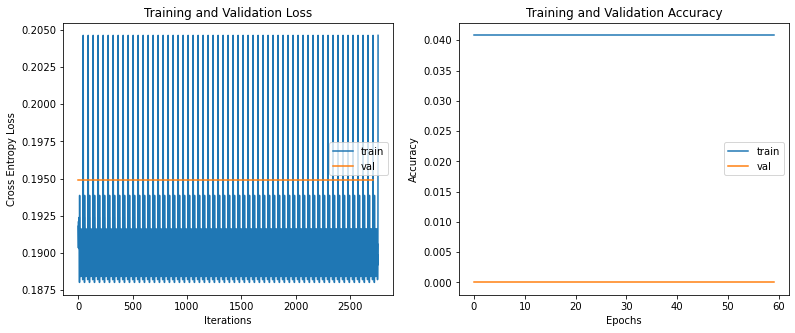

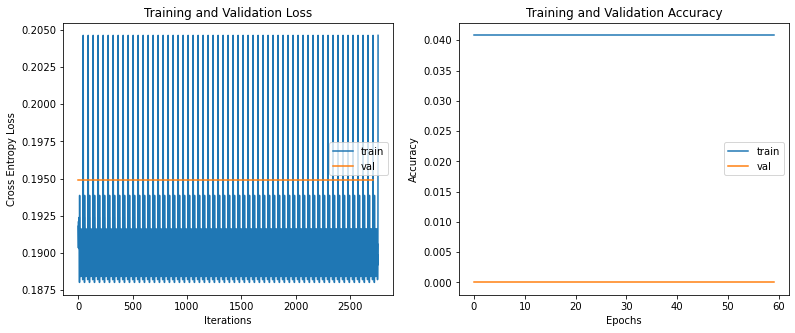

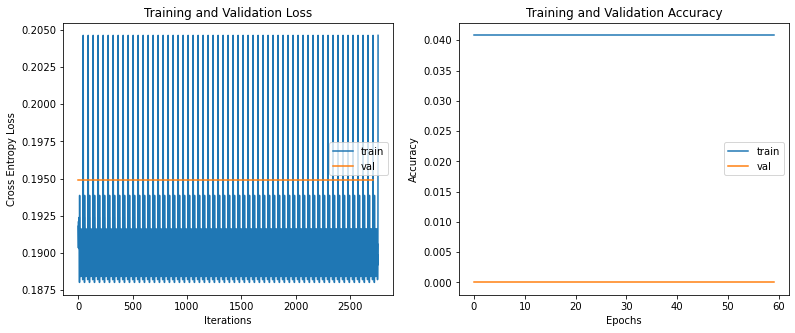

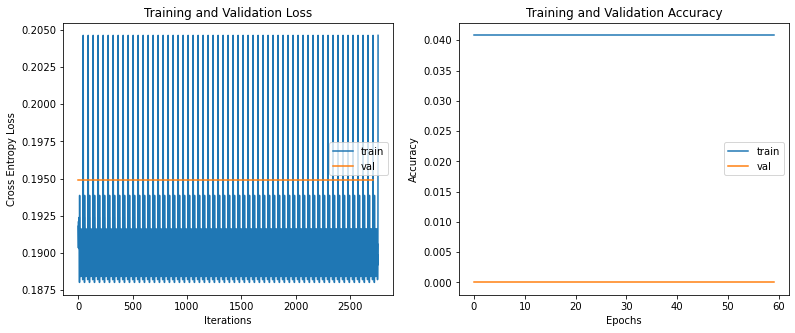

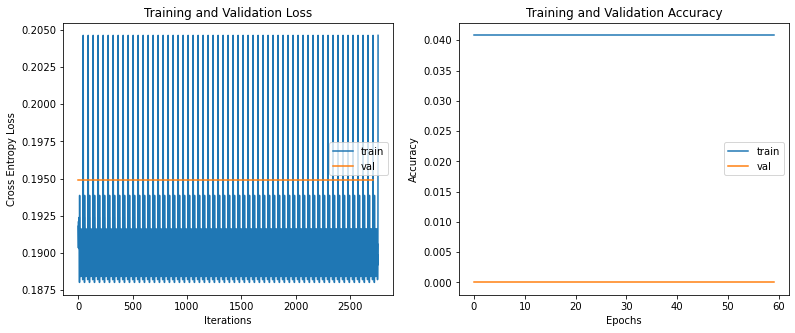

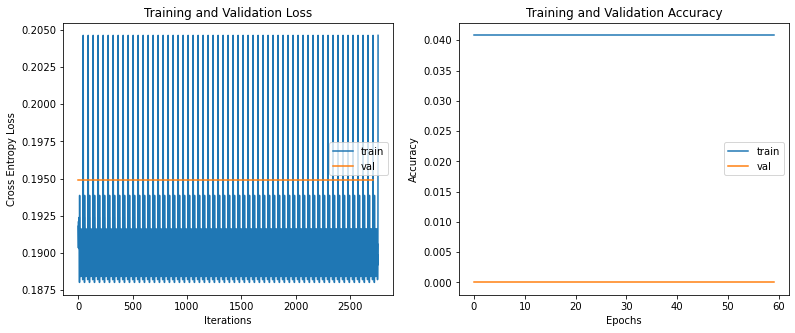

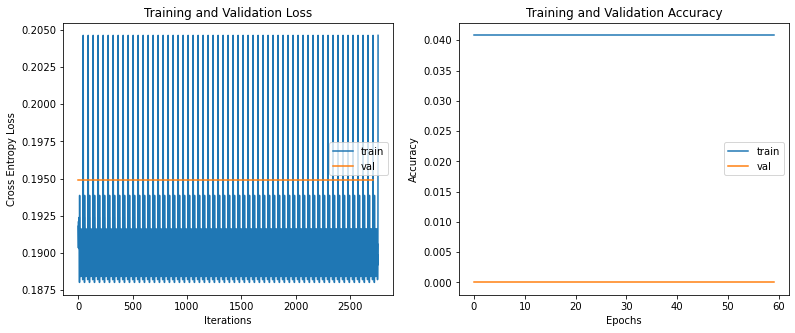

In [88]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]

for batch in batch_sizes:
  train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
  val_dataset_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
  test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
  
  model01 = LeNet8(3, 21)
  model01.to(device)
  optimizer = optim.Adam(model01.parameters(), lr=0.001)

  train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
  visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
  #del checkpoint
  del model01
  
  with torch.no_grad():
    torch.cuda.empty_cache()

##### 02. Use different learning rates

In [92]:
model = LeNet8_U(3, 21)
model.to(device)
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    9600    |
|  conv1.bias  |    128     |
| conv2.weight |   409600   |
|  conv2.bias  |    128     |
| conv3.weight |   204800   |
|  conv3.bias  |     64     |
| conv4.weight |   51200    |
|  conv4.bias  |     32     |
| conv5.weight |   12800    |
|  conv5.bias  |     16     |
|  fc1.weight  |    4096    |
|   fc1.bias   |     16     |
|  fc2.weight  |    512     |
|   fc2.bias   |     32     |
|  fc3.weight  |    2048    |
|   fc3.bias   |     64     |
|  fc4.weight  |    1344    |
|   fc4.bias   |     21     |
+--------------+------------+
Total Trainable Params: 696501


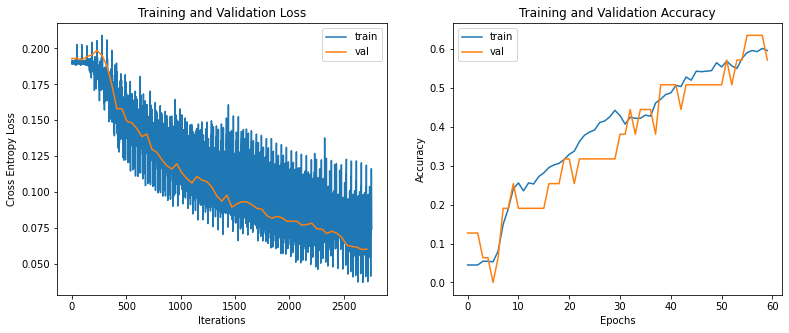

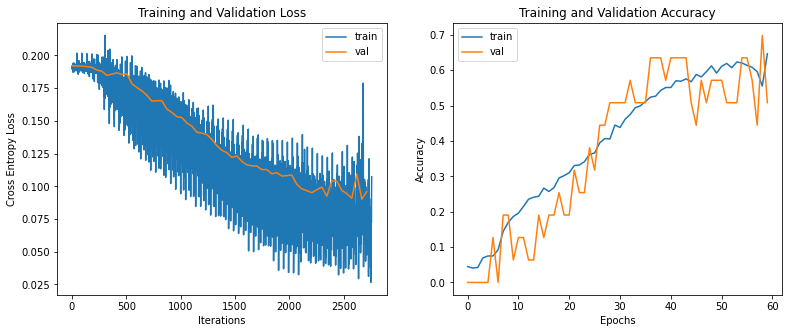

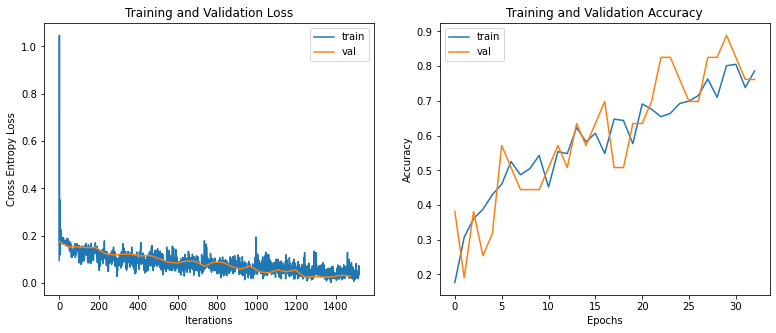

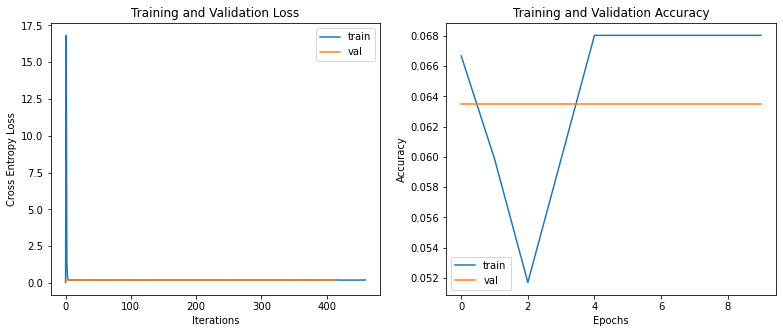

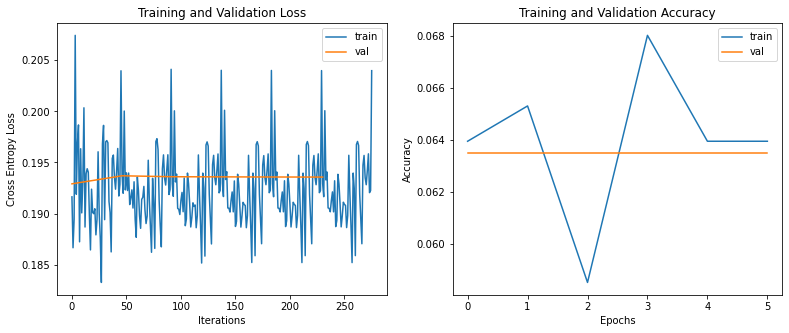

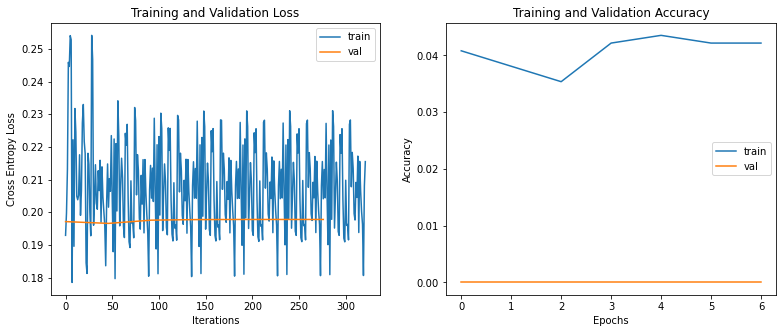

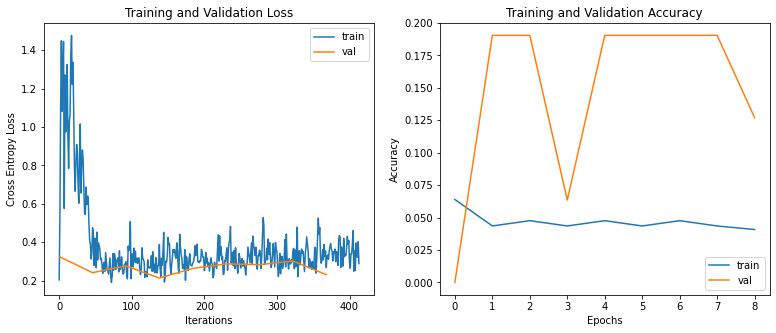

In [93]:
learning_rates = [10**i for i in range(-4, 2)] # using a logarithmic scale
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)

for lr in learning_rates:
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
  visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
  #del checkpoint
  
  with torch.no_grad():
    torch.cuda.empty_cache()

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.

## Exercise 3: Regularization & Co

For each of the following step, see how the performance of your network evolves:
* Add a regularization term to the loss function
* Add dropout
* Add batch-normalisation
* Try to add some data augmentation techniques. You should modify `transforms` (https://pytorch.org/vision/stable/transforms.html). Note that data augmentation techniques should be applied only to training data. (You can also add a data normalization step.)

##### 01. Add a regularization term to the loss function

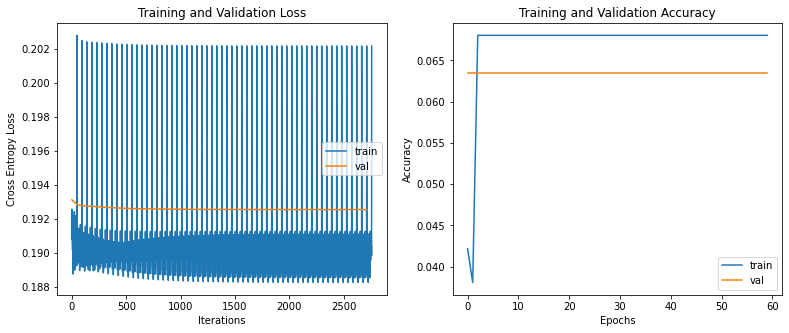

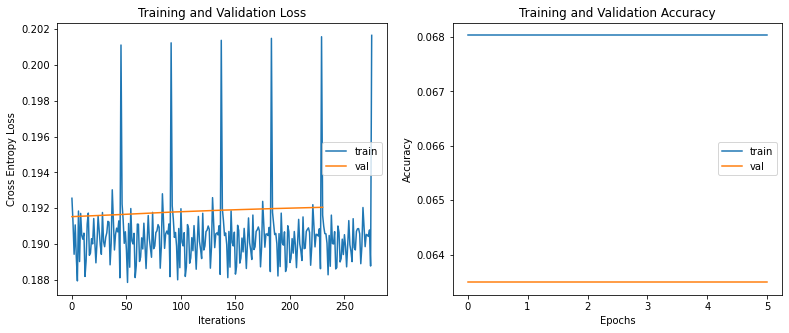

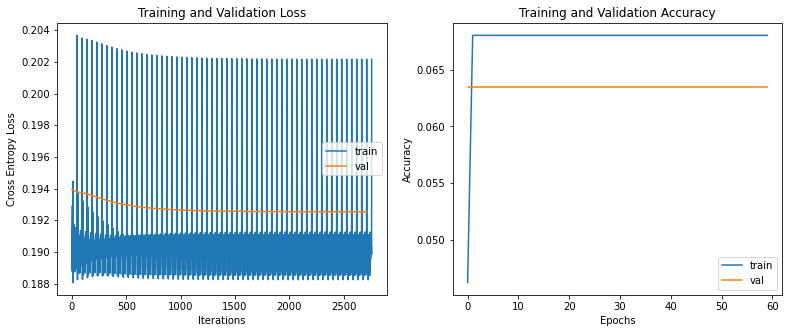

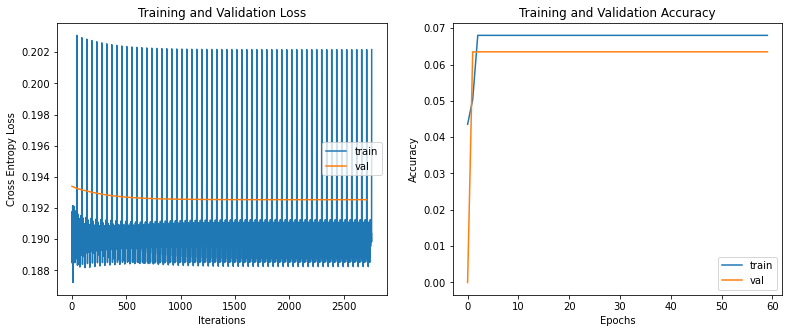

In [96]:
regularizer_param = [0.01, 0.1, 0.2, 0.5]


for reg in regularizer_param:
    model = LeNet8_U(3, 21)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
    visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
    del model
    with torch.no_grad():
        torch.cuda.empty_cache()

Comment the different results. Write a summary of what you observed for each experiment and describe the key findings below.


##### 02. Add DropOut to the model architecture

In [ ]:
class LeNet8_U_D(nn.Module):
  """
  Add a new Conv2Dlayer to the Let-Net7 architecture, 
  and two Linear Layers to the MLP component of the model architecture.
  Adjust the structure of the MaxPool and Activation functions
  """
  def __init__(self, n_channels, n_classes):
        super(LeNet8_U_D, self).__init__()

        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv6 = nn.Conv2d(128, 256, 3)

        # DROPOUT
        self.dropout = nn.Dropout(0.25)

        #-- fully connected layers
        self.fc1 = nn.Linear(256*1*1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_classes)
        
  def forward(self, x):
        # forward pass
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)
        x = self.dropout(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

In [ ]:
model = LeNet8_U_D(3, 21)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)

visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
    
del model
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
class LeNet8_U_D_B(nn.Module):
  """
  Add a new Conv2Dlayer to the Let-Net7 architecture, 
  and two Linear Layers to the MLP component of the model architecture.
  Adjust the structure of the MaxPool and Activation functions
  """
  def __init__(self, n_channels, n_classes):
        super(LeNet8_U_D_B, self).__init__()

        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, 3)
        self.conv6_bn = nn.BatchNorm2d(256)

        # DROPOUT
        self.dropout = nn.Dropout(0.25)

        # BATCHNORM
        self.batchnorm1 = nn.BatchNorm1d()
        self.batchnorm2 = nn.BatchNorm2d()

        #-- fully connected layers
        self.fc1 = nn.Linear(256*1*1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_classes)
        
  def forward(self, x):
        # forward pass
        x = self.conv1(x)
        x = F.max_pool2d(F.relu(self.conv1_bn(x)), 2)
        x = self.conv2(x)
        x = F.max_pool2d(F.relu(self.conv2_bn(x)), 2)
        x = self.conv3(x)
        x = F.max_pool2d(F.relu(self.conv3_bn(x)), 2)
        x = self.conv4(x)
        x = F.max_pool2d(F.relu(self.conv4_bn(x)), 2)
        x = self.conv5(x)
        x = F.max_pool2d(F.relu(self.conv5_bn(x)), 2)
        self.conv6(x)
        x = F.max_pool2d(F.relu(self.conv6_bn(x)), 2)
        x = self.dropout(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(nn.BatchNorm1d(self.fc1(x), 256))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        return logits

In [ ]:
model = LeNet8_U_D_B(3, 21)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)

visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
    
del model
with torch.no_grad():
    torch.cuda.empty_cache()

##### Image data augmentation
In this section, we will try some of the image augmentation techniques available in PyTorch. 
- Resize, 
- Flipping, 
- Rotating

In [ ]:
total_dataset

In [ ]:
batch_size = 16

transform = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(p=0.25), 
                                transforms.RandomVerticalFlip(p=0.25),
                                transforms.RandomRotation(degrees=(-90, 90)),
                                transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]), # normalize data
                                #transforms.ToTensor()
])

total_dataset = datasets.ImageFolder('./UCMerced_LandUse/Images', transform=transform)
print("Total number of images: ", len(total_dataset))
train_size = int(0.5 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print("Training set size: ", len(train_dataset))
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
print("Validation set size: ", len(val_dataset))
val_dataset_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
print("Test set size: ", len(test_dataset))
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [ ]:
dataiter = iter(train_dataset_loader)
images, labels = dataiter.next()
show_images(make_grid(images))

In [ ]:
model = LeNet8_U(3, 21)
model.to(device)
count_parameters(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loss, train_accuracy, val_loss, val_accuracy = train_model(model, optimizer,  epochs = 60)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy)
#del checkpoint
with torch.no_grad():
    torch.cuda.empty_cache()

## Exercise 4: Prediction on test

Once you have a model that seems satisfying on the validation set, you should evaluate it on a test dataset that has never been used before in order to obtain a final accuracy value.

Reload the checkpoint for your best model, which minimises the validation loss, and compute the test accuracy for this model.

In [ ]:
# your code comes here
optimalModel = LeNet8_U(3, 21)
optimalModel.to(device)
optimizer = optim.Adam(optimalModel.parameters(), lr=0.001, weight_decay=0.01)
train_loss, train_accuracy, val_loss, val_accuracy = train_model(optimalModel, optimizer, epochs = 80)
visualize_loss(train_loss, train_accuracy, val_loss, val_accuracy, epochs = 80)


In [ ]:
optimalModel(test_dataset)

In [ ]:
torch.save(optimalModel.state_dict(), "data/model/bestmodel_checkpoint.pth")

In [ ]:
checkpoint = torch.load("data/model/bestmodel_checkpoint.pth")

In [ ]:
best_model = LayeredMLP(patch_size*patch_size, 256, K, device=device)
best_model.load_state_dict(
    torch.load("data/model/bestmodel_checkpoint.pth")
)
best_model.eval()

# predict
predictions = best_model(test_dataset)
predicted_class = torch.argmax(predictions.detach(), axis = 1)

In [ ]:
test_dataset = train_test_split

In [ ]:
test_accuracy = torch.sum(predicted_class==Y_test_t)/len(Y_test_t)
test_accuracy

In [ ]:
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (best_model, metrics.classification_report(Y_test_t.detach().cpu(), predicted_class.cpu())))